In [0]:
#importing the classes required for the data set to process

In [1]:
from tensorflow.keras.layers import Input,MaxPool2D,Conv2D,Dense,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LeakyReLU,add,Activation
import tensorflow as tf
from tensorflow.keras.layers import Reshape,UpSampling2D,ZeroPadding2D,Concatenate,Lambda
import tensorflow.keras.backend as K
import numpy as np
import os
import cv2
import random
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping,ReduceLROnPlateau,TensorBoard
from tensorflow.keras import optimizers
import sys
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.python.framework import graph_io

Defining the parameters required for the yolo v3 its the 
same as Darknet 53 model

In [0]:
m = 0.9
e = 0.0005
l_r = 0.001
ra = 0.1
img_rows= 416
img_cols = 416
num_channels = 3
input_shape = (416,416)

#Definition of anchors as per the paper:

anchors = np.array([[10,13],[16,30],[33,23],[30,61],[62,45],[59,119],[116,90],[156,198],[373,326]])
mask = 0,1,2
jitter = .3
ignore_thresh=0.7
truth_thresh = 1

dic={0:'falcon', 1:'goose', 2:'great argus', 3:'kingfishers', 4:'parrots', 5:'penguins', 6:'rails', 7:'secretary bird', 8:'bee-eater', 9:'bittern', 10:'bulbuls', 11:'chachalaca', 12:'crane', 13:'cuckoos', 14:'curassow', 15:'duck', 16:'eagle',17:'erget', 18:'francolin', 19:'guan', 20:'hawk',21: 'heron', 22:'hornbill',23: 'ibis',24: 'kite',25: 'motmot',26: 'mynas',27: 'owls',28: 'partridge',29: 'peafowl',30: 'pelicans',31: 'pheasant',32: 'pigeons',33: 'pittas',34: 'quail',35: 'screamers',36: 'shorebirds',37: 'sparrow',38: 'spoonbill',39: 'spurfowl',40: 'storks',41: 'swan',42: 'tody',43: 'toucans',44: 'tragons',45: 'trgopan',46: 'turacos',47: 'vulture',48: 'woodpeckers'}

num_classes = len(dic)

Defining the YOLO residual and functional layers


In [0]:
#Following the custom model for the yolo networks. The block represents the residual blocks for the same
#Note using Batch Normalization after using convolution layers
def residual_darknet53(Inp,num_Filters):
  x = Conv2D(num_Filters,kernel_size=(1,1),use_bias=False,kernel_regularizer = l2(5e-4))(Inp)
  x = BatchNormalization(axis = -1,momentum = m,epsilon=e)(x)
  x = LeakyReLU(alpha = ra)(x)

  x = Conv2D(num_Filters*2,kernel_size=(3,3),padding='same',use_bias=False,kernel_regularizer = l2(5e-4))(x) 
  x = BatchNormalization(axis = -1,momentum=m,epsilon=e)(x)
  x =  LeakyReLU(alpha = ra)(x)
  return x 

def residual_blk_darknet(Inp,num_Filter):
  x = Inp
  y = Inp
  y = residual_darknet53(y,num_Filter)
  x = add([x,y])
  return x  

In [0]:
#Standard convolution layers used for striding
def conv2DDownSample(Inp,num_Filter):
  x=ZeroPadding2D(((1,0),(1,0)))(Inp)
  x=Conv2D(num_Filter,kernel_size=(3,3),strides=(2,2),use_bias=False,kernel_regularizer = l2(5e-4))(x)
  x=BatchNormalization(axis=-1,momentum=m,epsilon=e)(x)
  x=LeakyReLU(alpha=ra)(x)
  return x 

#Standard initial convolution layer without striding
def conv2d_block(Inp,filters,kernel):
  x = Conv2D(filters,kernel_size=(kernel,kernel),padding='same',use_bias=False,kernel_regularizer = l2(5e-4))(Inp)
  x = BatchNormalization(axis = -1,momentum=m,epsilon=e)(x)
  x = LeakyReLU(alpha=ra) (x)
  
  return x

def conv2d_block_bias(Inp,filters,kernel):
  x = Conv2D(filters,kernel_size=(kernel,kernel),padding='same',kernel_regularizer = l2(5e-4))(Inp)  
  return x

In [0]:
#Base model:

def darknet_53(inp):
  #Inp = Input(shape=(img_rows,img_cols,num_channels))
  x = conv2d_block(inp,32,3)
  x = conv2DDownSample(x,64) #downsampling part1
  x = residual_blk_darknet(x,32) #residual block with activation linear
  x = conv2DDownSample(x,128) #convolution downsampling
  for _ in range(2):
    x = residual_blk_darknet(x,64)
  x = conv2DDownSample(x,256) #convolution downsampling
  for _ in range(8):
      x = residual_blk_darknet(x,128)
  route_1 = Model(inp,x)
  x = conv2DDownSample(x,512) #convolution downsampling
  for _ in range(8):
      x = residual_blk_darknet(x,256)
  route_2 = Model(inp,x)
  x = conv2DDownSample(x,1024) #convolution downsampling    
  for _ in range(4):
      x = residual_blk_darknet(x,512)
  model = Model(inp,x)
  return route_1,route_2,model     


In [0]:
#The pyramidal feature mapping of the yolo. The following layers are added at different layers of the base model The pyramid network extracts the features at 3 different scales. At the output pf the base model we get the data of grid size 13x13
#Since the data has neem down sampled 5 times assuming the data size as 416 it self. 
#The data added at the last layer with some convolution strides. 2 routes are defined for the same: 
#The feature scaling factor is similar to the one used in the standard residual networks. 


def yolo_convolution_block(inputs,filters,out_filters):
  print(out_filters)
  inputs = conv2d_block(inputs,filters,kernel=1)
  inputs = conv2d_block(inputs,filters*2,kernel=3)
  inputs = conv2d_block(inputs,filters,kernel=1)
  inputs = conv2d_block(inputs,filters*2,kernel=3)
  inputs = conv2d_block(inputs,filters,kernel=1)

  route = inputs

  inputs = conv2d_block(inputs,filters*2,kernel=3)
  inputs = conv2d_block_bias(inputs,out_filters,kernel=1)
  
  return route,inputs
  
#The data obtained from the layers above is obtained as darknet 53 route1 route2  the below function forms the yolo body. The first layer gives the feature maps at layer 13x13 second at 26x26 and 3rd at 52x52 respectively. 
def yolo_body(inputs,num_anchors,num_classes):
  route1,route2,darknet53 = darknet_53(inputs)
  
  #the second last layer of darknet 53 contains 512 filters
  route,last1 = yolo_convolution_block(darknet53.output,512,num_anchors*(num_classes+5))
  #upsampling the 2nd last layer
  route = conv2d_block(route,256,1)
  route = UpSampling2D((2,2))(route)
  
  route = Concatenate()([route,route2.output])
  #repeating the same process for the 2nd last layer
  #256 as the second to the second last layer makes use of 256 filters
  route,last2 = yolo_convolution_block(route,256,num_anchors*(num_classes+5))
  
  #downsampling it further
  route = conv2d_block(route,128,1)
  route = UpSampling2D((2,2))(route)
  route = Concatenate()([route,route1.output])
  
  #repeating the process for the final time
  route,last3 = yolo_convolution_block(route,128,num_anchors*(num_classes+5))
  return Model(inputs,[last1,last2,last3])
  #Adding the upsampled feature with the output layer-1


In [0]:
#Based on the outputs obtained from the last layer we can further generate to predict box center height width and center points. 

def yolo_head(feats,anchors,num_classes,input_shape,calc_loss=False):
  """
  Converting the final layer obtained to bounding box parameters

  Parameters are defined as follows:
  ----------------------------------
  feats: tensor
    Final convolution layer features
    anchors : array-like Anchor-box width and height
    num_classes:int
    Number of target classes

  Returns: 
  box_xy:tensor x,y prediction adjusted by spatial location in convlayer (each of the feature map level)
  box_wh: tensor: w,h predictions adjusted by anchors and conv spatial resolution (each of the feature map level)
  box_conf:tensor: Probability estimate to indicate whether the box contains an object or not (confidence score )
  box_class_pred: tensor: Probability destribution of the box for each of the labels  (class prediction)
  """
  #Defining the number of anchors
  num_anchors = len(anchors)
  #Reshaping it to batch,height,width,num_anchors,box_parameters [1,1,1,9,2 ] 9 anchors and 2 coordinates width and height
  anchors_tensor = K.reshape(K.constant(anchors),[1,1,1,num_anchors,2])
  
  #This assumes the 1st and 3rd index position belongs to the width and height feats is a 5 vector consisting of 0: confidence score 1: height 2: width 3: x_point 4: y_point coordinate 5: onwards class prediction
  grid_shape = K.shape(feats)[1:3] #height and width
  #creating a cell mesh
  #Dymamic implementation of conv dims for fully convolutional mode
  #The first value of the grid shape indicates the height. This will convert the height and width in tha array grid of the mentioned size. Each element is repeated per row value
  grid_y = K.tile(K.reshape(K.arange(0,stop=grid_shape[0]),[-1,1,1,1]),[1,grid_shape[1],1,1])
  #Second value of the grid shape indicates the width. This indicates the 
  grid_x = K.tile(K.reshape(K.arange(0,stop=grid_shape[1]),[1,-1,1,1]),[grid_shape[0],1,1,1])
  """
  e.g if grid[0],grid[1]=3
  then values will be:
  grid_y  grid_x
  0 0 0   0 1 2
  1 1 1   0 1 2  
  2 2 2   0 1 2
  
  Thus forming a grid
  """
  grid= K.concatenate([grid_x,grid_y])
  """
  The above step will do the below
  (0,0) (0,1) (0,2)
  (1,0) (1,1) (1,2)
  (2,0) (2,1) (2,2)
  """
  #Converting the grid obtained data type of the last convolution layer. The grid points are basically at 13x13 26x26 and 52x52

  grid = K.cast(grid,K.dtype(feats))
  #Reshaping the tensor obtained out after the resizing operation
  #Values are reshaped as  -1 : batch size height width number of anchors number of classes
  """
  The value obtained from the last layer are seperated at each grid point. 13x13 26x26 and 52x52 respectively. 
  
  Each point is responsible for predicting a value of the box

  """
  feats =K.reshape(feats,[-1,grid_shape[0],grid_shape[1],num_anchors,num_classes+5])
  
  #box_x = K.sigmoid(feats[...,0]+grid_x)/K.cast(grid_shape[1],K.dtype(feats))
  #box_y = K.sigmoid(feats[...,1]+grid_y)/K.cast(grid_shape[0],K.dtype(feats))
  #Center point creation normalized to height and width coordinates
  
  #K.sigmoid(feats[...,:2]) converts the center coordinates to values between 0 and 1
  #grid adds the height and width values to it
  #This value is furtherd divided with the height and widht to normalization
  """
  x and y values are predicted as: 
  bx = sigmoid(pred_x)+cx/width
  by = sigmoid(pred_y)+cy/height
  """

  box_xy = (K.sigmoid(feats[...,:2])+grid)/K.cast(grid_shape[::-1],K.dtype(feats))
  #Width and height extraction normalized to height and width coordinates
  #Same process follow here apart from the fact that the expected height and width are multiplied with the anchor tensores. 
  """
  Width and height are calculated as below: 
  bw = pw*e^(tw)
  bh = ph*e^(th)

  pw and ph are the values of the anchor tensors 
  The values of bw and bh are further normalized with respect to height and width values
  """

  box_wh = K.exp(feats[...,2:4])*anchors_tensor/K.cast(input_shape[::-1],K.dtype(feats))
  #Prediction of the confidence of the box
  """
  Box confidence is calculated and normalized between 0 to 1
  """
  box_confidence = K.sigmoid(feats[...,4:5])
  #Preiction of each of the class probabilites 
  """
  Class probabilites of different classes are calculated and normalized between 0 and 1
  """
  
  box_class_probs = K.sigmoid(feats[..., 5:])
  #Incase of testing the not returning confidence
  if calc_loss == True:
    """
    While training of the yolo grid size (feature map size) the last layer resized and further center coordinates x,y and w and h are calculated
    """
    return grid,feats,box_xy,box_wh
  #Returning confidence as a part of the yolo heading  
  return box_xy,box_wh, box_confidence,box_class_probs 

Defining the yolo loss functions

In [0]:
"""
Defining the box IOU (intersection over union). Given 2 boxes this gives the maximum area covered by the 2 boxes. 
IOU being defined as: 

IOU = (Intersection-Area)/(Union Area: box1-Area + box2-Area -  Intersection area)
"""

def box_iou(b1,b2):
  """
  Returning the iou tensor
  Parameters: 
  ----------
  b1: tensor of shape (i1,...,iN,4),xywh
  b2: tensor, shape = (j,4), xywh

  Returns
  ------------------------
  iou tensor,shape = (i1,...,iN,j)
  """
  #Expand dim to apply broadcasting:
  """
  Seperares the box height and width with the center coordinates. 
  """
  b1 = K.expand_dims(b1,-2)
  #First 2 coordinates as heigy and width
  b1_xy = b1[...,:2]
  b1_wh = b1[...,2:4]
  b1_wh_half = b1_wh/2.
  b1_mins = b1_xy-b1_wh_half
  b1_maxes = b1_xy + b1_wh_half

  #Expanding 2nd box
  b2 = K.expand_dims(b2,0)
  b2_xy = b2[...,:2]
  b2_wh = b2[...,2:4]
  b2_wh_half = b2_wh/2.
  b2_mins = b2_xy-b2_wh_half
  b2_maxes =b2_xy + b2_wh_half
  intersect_mins = K.maximum(b1_mins,b2_mins)
  intersect_maxes = K.minimum(b1_maxes,b2_maxes)
  intersect_wh = K.maximum(intersect_maxes-intersect_mins,0)
  intersect_area = intersect_wh[...,0]* intersect_wh[...,1]
  b1_area = b1_wh[...,0]*b1_wh[...,1]
  b2_area = b2_wh[...,0]*b2_wh[...,1]
  iou = intersect_area/(b1_area + b2_area - intersect_area)

  return iou

In [0]:
def yolo_loss(args,anchors,num_classes,ignore_thres=.5,print_loss=True):
  #The number of feature scaling. 
  num_layers = len(anchors)//3 #default setting This defined the number of anchors used per scale. More than one scale values used will cause the number of layers to be increased. accordingly. 
  #Prediction made at each of the feature level
  yolo_outputs = args[:num_layers]
  #yolo_outputs = K.print_tensor(yolo_outputs,message="yolo_layer_output:")
  #Predicted output of the mentioned inputs
  y_true = args[num_layers:]
  #y_true = K.print_tensor(y_true,message="y_true:")
  #The anchor mask outputs
  
  anchor_mask = [[6,7,8],[3,4,5],[0,1,2]] if num_layers==3 else [[3,4,5],[1,2,3]]
  
  input_shape = K.cast(K.shape(yolo_outputs[0])[1:3]*32,K.dtype(y_true[0]))
  #Grid shape based on the yolo outputs
  
  grid_shapes = [K.cast(K.shape(yolo_outputs[l])[1:3],K.dtype(y_true[0])) for l in range(num_layers)]
  """
  loss value is initialized to 0
  """
  
  loss = 0
  #Batch size 
 

  m = K.shape(yolo_outputs[0])[0] #batch size, tensor
  #Converting batch size to float
  mf = K.cast(m,K.dtype(yolo_outputs[0]))
  #mf = K.print_tensor(mf,message="mf:")
  for l in range(num_layers):
    #Getting the object mask layer this gives the confidence layer. Objectiveness of each of the true values
    object_mask = y_true[l][...,4:5]
    #object_mask = K.print_tensor(object_mask,message="object_mask:")
    #Getting the true class probabilities. Each of the confidence score for the class values
    true_class_probs = y_true[l] [...,5:]
    #true_class_probs = K.print_tensor(true_class_probs,message="true_class_probs:")
    
    grid,raw_pred,pred_xy,pred_wh = yolo_head(yolo_outputs[l],anchors[anchor_mask[l]],num_classes,input_shape,calc_loss=True)
    #grid = K.print_tensor(grid,message="grid:")
    #raw_pred = K.print_tensor(raw_pred,message="raw_pred:")
    #pred_xy = K.print_tensor(pred_xy,message="pred_xy:")
    #Concatenating the the center point and width and height coordinates
    
    pred_box = K.concatenate([pred_xy,pred_wh])
    #pred_box = K.print_tensor(pred_box,message="pred_box:")
    
    #Darknet raw box to calculate loss. 
    #Converting the raw true values in to values yolo predicts
    raw_true_xy = y_true[l][...,:2]*grid_shapes[l][::-1] -grid #grid acts as an offset
    #raw_true_xy = K.print_tensor(raw_true_xy,message="raw_true_xy:")
    raw_true_wh = K.log(y_true[l][...,2:4]/anchors[anchor_mask[l]]*input_shape[::-1])
    #raw_true_wh = K.print_tensor(raw_true_wh,message="raw_true_wh:")
    raw_true_wh = K.switch(object_mask,raw_true_wh,K.zeros_like(raw_true_wh))  #this is to avoid log(0) = -inf
    #raw_true_wh = K.print_tensor(raw_true_wh,message="raw_true_wh:")
    box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4]
    #box_loss_scale = K.print_tensor(box_loss_scale,message="box_loss_scale:")
    
    #Find ignore mask, iterate over each of the batch.....

    
    ignore_mask = tf.TensorArray(K.dtype(y_true[0]),size=1,dynamic_size=True)
    #ignore_mask = K.print_tensor(ignore_mask,message="ignore_mask:")
    """
    For each of the batches this gives the value of the objectiveness score as either true or fakse
    """
    object_mask_bool = K.cast(object_mask,'bool')

    def loop_body(b,ignore_mask):
      """
      This returns a value of true box which is masked by boolean threshold
      If the objectiveness of the mask is 0 not not present then the loss is 
      simply not calculated. 
      """
      #Gives only those boxes which has object in them
      true_box = tf.boolean_mask(y_true[l][b,...,0:4],object_mask_bool[b,...,0])
      """
      At a particular batch the IOU is calculated and returned. The best of the predicting anchor is stored as 
      best_iou: the values of the best IOU remain: batch, index of anchor matching the most

      """
      #IoU
      iou = box_iou(pred_box[b],true_box)
      best_iou = K.max(iou,axis=-1)
      """
      Incase the threshold covered is very low then it is writtened in the ignore_mask tensor. 
      """
      ignore_mask = ignore_mask.write(b,K.cast(best_iou<ignore_thres,K.dtype(true_box)))
      return b+1,ignore_mask
    """
    For all the values the input argument and the batch size the values are calculated. for the mask whose IOU is less then the threshold
    """
    _,ignore_mask=tf.while_loop(lambda b,*args: b<m,loop_body,[0,ignore_mask])
    #K.control_flow_ops.while_loop(lambda b,*args: b<m,loop_body,[0,ignore_mask])
    """
    The mask are further stacked. This is used in the calculation of the confidence loss
    """
    ignore_mask = ignore_mask.stack()
    ignore_mask = K.expand_dims(ignore_mask,-1)
    #ignore_mask = K.print_tensor(ignore_mask,message="ignore_mask:")
    t1 = K.sum(raw_true_wh)
    raw_true_wh = K.switch(tf.math.is_inf(t1),K.zeros_like(raw_true_wh),raw_true_wh)
    #t2 = K.print_tensor(K.sum(raw_pred[...,2:4]),message = 'pred_wh:')
    xy_loss = object_mask*box_loss_scale*K.binary_crossentropy(raw_true_xy,raw_pred[...,0:2], from_logits = True)
    #xy_loss = K.print_tensor(xy_loss,message="xy_loss:")
    
    wh_loss = object_mask *box_loss_scale*0.5*K.square(raw_true_wh - raw_pred[...,2:4])
    #K.print_tensor(K.sum(wh_loss),message="wh_loss:")
    
    confidence_loss = object_mask * K.binary_crossentropy(object_mask,raw_pred[...,4:5],from_logits=True) + (1-object_mask) * K.binary_crossentropy(object_mask,raw_pred[...,4:5],from_logits=True)*ignore_mask 
    #confidence_loss = K.print_tensor(confidence_loss,message="confidence_loss:")
    
    
    class_loss = object_mask *K.binary_crossentropy(true_class_probs,raw_pred[...,5:],from_logits=True)
    #class_loss = K.print_tensor(class_loss,message="class_loss:")
    """
    Loss is calculated: 

    xy_loss: objective mask*box_loss_Scale*binary_cross_entropy(true and predicted values ) 
   
    wh_loss: 1/2(raw_wh-raw_wh)^2*box_loss*objective_mask
    confidence_loss: objective_mask*binary_crossentropy(confidence_true,predicted)  + (1-objective_mask)*binary_crossentropy(object_mask,raw_predictions[...,4:5])
    class_loss: true class v/s binary_cross entropy
    The box loss is further normalized
    width and height are further normalized. 
    confidence_loss is summed and normalized 
    class_loss is normalized per batch 
    loss are summed xy_loss+ confidence_loss and class_loss
    """  
    
    xy_loss = K.sum(xy_loss) /mf

    
    
    wh_loss = K.sum(wh_loss) /mf
    #wh_loss = K.print_tensor(wh_loss,message="\nwh_loss after:")
    confidence_loss = K.sum(confidence_loss)/mf
    #confidence_loss = K.print_tensor(confidence_loss,message="confidence_loss:")
    class_loss = K.sum(class_loss)/mf

    #class_loss = K.print_tensor(class_loss,message="class_loss:")
    
    loss += xy_loss + wh_loss + confidence_loss + class_loss
    
   # loss = K.print_tensor(loss,message="loss")
    
    #tf.print("loss:",loss,[loss,xy_loss,wh_loss,confidence_loss,class_loss,K.sum(ignore_mask)],output_stream=sys.stdout)
  return loss  

Creation of the data generator function

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
"""
Creating a dictionary of the input images and the classes. 
"""

weights_dir = "/content/drive/My Drive/Colab Notebooks/"
data_dir= "/content/drive/My Drive/Colab Notebooks/DataSet"
Img_dir = "/content/drive/My Drive/Colab Notebooks/DataSet/Image"
Lab_dir = "/content/drive/My Drive/Colab Notebooks/DataSet/Label"
image_data = sorted(os.listdir('/content/drive/My Drive/Colab Notebooks/DataSet/Image'))
label_data = sorted(os.listdir('/content/drive/My Drive/Colab Notebooks/DataSet/Label'))

In [13]:
print(f"The number of Images in the dataset include {len(image_data)}")
print(f"The corresponding labels in the dataset include {len(label_data)}")

The number of Images in the dataset include 15048
The corresponding labels in the dataset include 15048


In [0]:
image_id = {i: d for i,d in enumerate(image_data)}
label_id = {i:d for i,d in enumerate(label_data)}

In [0]:
def read_img(index,shape):
  img = cv2.imread(Img_dir+'/'+image_id[index]) 
  w,h = img.shape[:2]
  if (w,h)<shape:
    img = cv2.resize(img,shape,interpolation=cv2.INTER_CUBIC)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = np.array(img)/255.
  return img 

def display_img(index):
  img = cv2.imread(Img_dir+'/'+image_id[index])
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.figure()
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  plt.close()

def readLabel(index):
  print(label_id[index])
  lines=open(Lab_dir+'/'+label_id[index],'r')
  s = lines.readlines()
  l=[]
  for i in s:
    i = i.strip()
    if len(i)>1:
      a = i.strip().split(' ')
      d = []
      k = 0
      for j in a:
        if len(j)!=0:
          if k==0:
            d.append(float(j))
            k = k+1
          else:
             if float(j)>1:
               d.append(float(1)) 
             else: 
               d.append(float(j))  
      a = np.array(d)
      a = np.roll(a,-1)
      l.append(a)
  l = np.array(l)  
  lines.close()
  return l 

In [16]:
#Splitting the indexes into testing and training: 
#Creation of the index datafile: 
indexes = list(image_id.keys())
np.random.seed(30)
total_data = len(indexes)
random.shuffle(indexes)
splits = 0.999
train_index = indexes[:int(splits*total_data)]
test_index = indexes[int(splits*total_data):]
train_len = len(train_index)
test_len = len(test_index)
print(train_len,test_len)

15032 16


In [0]:
#Creation of a function for the validation of the appropriate bounding box for the image

def preprocess_box_anchors(true_boxes,input_shape,anchors,num_classes):
  """
  true boxes: array of shape (batch_Size,size of labels per image,labels)
  input_shape is the shape of the array multiples of 32
  anchors are the anchors used shape = N,2 w h  format
  num_classes:integer
  Returns
  -------------------------------
  y_true : list of array shaped liked yolo output for loss comparision
  y_true is of the size m:batch_size,h,w :feature map size,objectivenss,bounding_box+objectivness_class prediction
  """
  #print(true_boxes)
  num_layers = len(anchors)//3
  anchor_mask = [[6,7,8],[3,4,5],[0,1,2]] if num_layers == 3 else [[3,4,5],[1,2,3]]
  boxes_xy = true_boxes[...,0:2]*input_shape

  boxes_wh = true_boxes[...,2:4]*input_shape  
  #print(boxes_xy)
  #print(boxes_wh)
  true_boxes =np.array(true_boxes,dtype='float32')
  input_shape = np.array(input_shape,dtype='int32')
  m = true_boxes.shape[0] #batch_size
  grid_shapes = [input_shape//{0:32,1:16,2:8}[l] for l in range(num_layers)]
  # initializing y_true values {Array of predictions across the grid} number of anchors 4 priors 1 confidence and number of clases
  """
  y_true has size b:batches width,height,number of anchor per layer, 4 box + 1 confidence + class
  """
  y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),dtype = 'float32') for l in range(num_layers)]
  anchors = np.expand_dims(anchors,0)
  anchor_maxes = anchors/2.
  anchor_mins = -anchor_maxes
  valid_mask = boxes_wh[...,0]>0

  for b in range(m):
    # discard zero rows. 
    # Calculating the width and height of the valid mask. 
    wh = boxes_wh[b,valid_mask[b]]
    if len(wh)!=0:
      wh = np.expand_dims(wh,-2)
      box_maxes = wh/2.
      box_mins = -box_maxes
      intersect_mins = np.maximum(box_mins,anchor_mins) #This gives the coordinates of the minimum value of the anchor box in the specified area
      intersect_maxes = np.minimum(box_maxes,anchor_maxes) #This gives the coordinates of the area lying within the anchor min
      """
    (a)--------------  (anchor_mins)
      |(i)---------(b) |   (negative)  box min intersect mean
      |  |        |    | 
      ---------------- (center point)            
      |  |        |    |   (positive)
      |  ---------(b i)|               box_max intersect max
      --------------(anchor_maxs)  

      """
      intersect_wh = np.maximum(intersect_maxes- intersect_mins,0.) 
      intersect_area = intersect_wh[...,0]*intersect_wh[...,1] #area = width*height
      box_area = wh[...,0] * wh[...,1]
      anchor_area = anchors[...,0]*anchors[...,1]
      iou = intersect_area / (box_area+anchor_area - intersect_area) #This gives intersect over union
      #finding box with heighest iou
      best_anchor = np.argmax(iou,axis=-1)
      for i1,i2 in enumerate(best_anchor):
        for l in range(num_layers):
          #Check if the value matches any anchor mask or not
          if i2 in anchor_mask[l]:
            #Calculating the height and width of the maximum obtained true box
            
            #print(true_boxes)
            i = np.floor(true_boxes[b,i1,0]*grid_shapes[l][1]).astype('int32') #Scaling to original coordinates
            if i == grid_shapes[l][1]:
              i = i-1
            j = np.floor(true_boxes[b,i1,1]*grid_shapes[l][0]).astype('int32') #Scaling to the value
            if j == grid_shapes[l][0]:
              j = j-1
            #print(i,j)
            #For each anchor mask trying to find which of the anchor mask fits the best
            #Value of the i2 if present in the anchor mask
            k = anchor_mask[l].index(i2)
            #Calculating the confidence score of the value predicted
            c = true_boxes[b,i1,4].astype('int32')
            #Assigning the box priors to y_true value
            y_true[l][b,j,i,k,0:4] = true_boxes[b,i1,0:4]
            #confidence
            y_true[l][b,j,i,k,4] = 1
            #class predictions
            y_true[l][b,j,i,k,5+c] = 1
  return y_true  


In [0]:
def get_data(index,input_shape,max_boxes = 20):  
    box_data = np.zeros((max_boxes,5))
    img = read_img(index,input_shape)
    labels = readLabel(index)
    if len(labels)>max_boxes:
      labels = labels[:max_boxes]
    box_data[:len(labels)] = labels
    #print(box_data)
    return img,box_data

In [0]:
class data_generator:
  def __init__(self,input_shape,anchors,num_classes,indexes,batch_size=32):
    self.cur_train_index=0
    self.batch_size= batch_size
    self.input_shape = input_shape
    self.anchors = anchors
    self.num_classes = num_classes
    self.indexes = indexes
    #self.num_samples = len(indexes)
  #The function would return the image data and the label value for the same
  #maximum number of boxes per image

  def next_train_data(self):
    while 1:
      image_data=[]
      boxes=[]
      for i in range(self.batch_size):
        if self.cur_train_index >= len(self.indexes):
          self.cur_train_index =0
        img,box = get_data(self.indexes[self.cur_train_index],self.input_shape) 
        #print(box)
        self.cur_train_index +=1
        image_data.append(img)
        boxes.append(box)
        #print(boxes)
      image_data = np.array(image_data)
      box_data = np.array(boxes)
      #print(box_data.shape)
      y_true = preprocess_box_anchors(box_data,self.input_shape,self.anchors,self.num_classes) 
      #print([image_data,*y_true],np.zeros(batch_size))  
      yield [image_data,*y_true],np.zeros(batch_size)

Creating the model for training images:

In [0]:
#Creating training model
def create_model(input_shape,anchors,num_classes):
  #creating of the input space for the model to be trained
  K.clear_session()
  input_image = Input(shape=(None,None,3))
  h,w = input_shape

  num_anchors = len(anchors)
  #default value of the true value value remains a list of 3 elements. 
  y_true = [Input(shape=(h//{0:32,1:16,2:8}[l],w//{0:32,1:16,2:8}[l],num_anchors//3,num_classes+5)) for l in range(3)]
  model_body = yolo_body(input_image,num_anchors//3 ,num_classes) #3 anchors per layer
  print(model_body.summary())
  """
  Loading pretrained yolov3 model weights
  """
  #model_body.load_weights(weights_dir+'yolo.h5')
  """
  Freezing the model till the dark net layer
  """
  #num = len(model_body.layers)-3
  #for i in range(num):
  #  model_body.layers[i].trainable = False
  #Creating customized loss layer
  #3 layers predicted tensor + true value of the same
  model_loss =  Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thres': 0.5})([*model_body.output, *y_true])
  model= Model([model_body.input,*y_true],model_loss)
  return model

In [15]:
seed = 30
np.random.seed(30)
optmz = optimizers.Adam(learning_rate = l_r)
model_name = "yolov3_retrain"
log_dir = '/content/drive/My Drive/Colab Notebooks/'
logging = TensorBoard(log_dir=log_dir)
filepath = "/content/drive/My Drive/Colab Notebooks/"+model_name+".h5py"
chekpoint= ModelCheckpoint(filepath,monitor='val_loss',save_weights_only=True,save_best_only=True)
csv_logger = CSVLogger("/content/drive/My Drive/Colab Notebooks/"+model_name+".csv")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
model = create_model(input_shape,anchors,num_classes)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
162
162
162
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, None, None, 3 0           batch_normalization[0][0]        

In [0]:
model.summary()

In [0]:
model.compile(optimizer=optmz,loss = {'yolo_loss':lambda y_true,y_pred:y_pred})


In [23]:
model.load_weights(filepath)

In [0]:
model.evaluate_generator(gen_val.next_train_data(),steps =max(1,test_len//batch_size))

In [0]:
batch_size=2
gen_train = data_generator(input_shape,anchors,num_classes,train_index,batch_size)
gen_val = data_generator(input_shape,anchors,num_classes,test_index,batch_size=batch_size)


Training on fixed loaded weights for about 30 epochs

In [0]:
model.fit_generator(gen_train.next_train_data(),steps_per_epoch = max(1,train_len//batch_size),validation_data=gen_val.next_train_data(),validation_steps=max(1,test_len//batch_size),epochs=1,callbacks=[chekpoint,csv_logger,reduce_lr,early_stopping,logging])

1354/1354 [==============================] - 14038s 10s/step - loss: 4.8456 - val_loss: 4.8709


In [0]:
image_id.keys()

In [0]:
model.load_weights(filepath)

In [0]:
model_f =  Model(model.layers[0].input,[model.layers[249].output,model.layers[250].output,model.layers[251].output])

In [0]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

In [0]:
def boundingboxes(youtput,anchors,num_classes):
  num_anchors = len(anchors)
  anchors = np.reshape(a,(1,1,1,num_anchors,2))
  grid_shape = np.shape(youtput)[1:3]
  grid_y = np.tile(np.reshape(np.arange(0,grid_shape[0]),[-1,1,1,1]),[1,grid_shape[1],1,1])
  grid_x =  np.tile(np.reshape(np.arange(0,stop=grid_shape[1]),[1,-1,1,1]),[grid_shape[0],1,1,1])
  grid = np.concatenate([grid_x,grid_y],axis=-1)
  youtput = np.reshape(youtput,[-1,grid_shape[0],grid_shape[1],num_anchors,num_classes+5])
  box_xy = (sigmoid(youtput[...,:2])+grid)/grid_shape[::-1]
  box_wh =  np.exp(youtput[...,2:4])*a
  box_confidence = sigmoid(youtput[...,4:5])
  box_class_probs = sigmoid(youtput[...,5:])
  box_yx = box_xy[...,::-1]*416
  box_hw = box_wh[...,::-1]
  box_mins = box_yx - (box_hw/2.)
  box_maxes = box_yx + (box_hw/2.)
  boxes = np.concatenate([box_mins[...,0:1],box_mins[...,1:2],box_maxes[...,0:1],box_maxes[...,1:2]],axis=-1)
  boxes = np.reshape(boxes,[-1,4])
  boxes_scores = box_confidence*box_class_probs
  boxes_scores = np.reshape(boxes_scores,[-1,num_classes])
  return boxes,boxes_scores

In [0]:
def non_max_suppression(boxes,thresh):
  if len(boxes)==0:
    return []

  pick = []
  y1 = boxes[:,0]
  x1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
  area = (x2-x1+1)*(y2-y1+1)
  idxs = np.argsort(y2)
  while len(idxs)>0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    yy1 = np.maximum(y1[i],y1[idxs[:last]])
    xx1 = np.maximum(x1[i],x1[idxs[:last]])
    xx2 = np.maximum(x2[i],x2[idxs[:last]])
    yy2 = np.maximum(y2[i],y2[idxs[:last]])
    w = np.maximum(0,xx2-xx1+1)
    h = np.maximum(0,yy2-yy1+1)
    overlap = (w*h)/area[idxs[:last]]
    idxs = np.delete(idxs,np.concatenate(([last],np.where(overlap>thresh)[0])))
  return pick  

In [0]:
def eval(img,anchors,num_classes=num_classes,max_boxes=20,score_threshold=0.2,iou_threshold=0.5):
  img = np.expand_dims(img,0)
  prediction = model_f.predict(img)
  num_layers = len(prediction)
  mask = [[6,7,8],[3,4,5],[0,1,2]]
  boxes = []
  box_scores = []
  for l in range(num_layers):
    _boxes,_box_scores = boundingboxes(prediction[l],anchors[mask[l]],num_classes)
    boxes.append(_boxes)
    box_scores.append(_box_scores)
  boxes = np.concatenate(boxes,axis=0)
  #print(boxes.shape)
  box_scores = np.concatenate(box_scores,axis=0)
  mask = box_scores >= score_threshold
  boxes_ = []
  scores_ = []
  classes_ = []
  for c in range(num_classes):
    class_boxes = boxes[mask[:,c]]
    #print(class_boxes)
    
    class_box_scores = box_scores[mask[:,c]]
    if class_boxes.shape[0]!=0:
      nms_index =non_max_suppression(class_boxes,0.5)
      class_boxes = class_boxes[nms_index]
      class_box_scores = class_box_scores[nms_index]
      c1=[]
      for i in class_box_scores:
        temp = (np.max(i))
        c1.append(temp)
      c1=np.array(c1)  
      classes = np.ones_like(c1)*c
      boxes_.append(class_boxes)
      scores_.append(c1)
      classes_.append(classes) 
  boxes_ = np.concatenate(boxes_,axis=0)
  scores_=np.concatenate(scores_,axis=0)
  classes_=np.concatenate(classes_,axis=0)
  return boxes_,scores_,classes_   



In [0]:
def draw_bounding(img_file,anchors,score_threshold=0.2):
  img = cv2.imread(img_file)
  img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img1 = cv2.resize(img1,(416,416))
  img1 = np.array(img1)/255.
  anchor,score,classes = eval(img1,anchors,score_threshold=score_threshold)
  #print(anchor[0][1],score[0],classes)
  for i in range(len(anchor)):
    #print(i)
    color = np.random.randint(0,255)
    #if score[i]>score_threshold:
    cv2.rectangle(img,(int(anchor[i][1]+0.5)-70,int(anchor[i][0]+0.5)-70),(int(anchor[i][3]+0.5)+70,int(anchor[i][2]+0.5)+70),(color,color,color),2)
    cv2.putText(img,dic[int(classes[i])],(int(anchor[i][1]+0.5+50)-1,int(anchor[i][0]+0.5+50)+1),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.figure()
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  plt.close()    


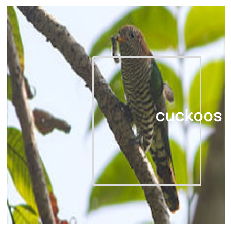

In [824]:
num = np.random.randint(0,len(image_data))
image = image_id[num]
draw_bounding(Img_dir+"/"+image,anchors,0.9)

Getting the subset of the layers used for actual yolo prediction

Open cv implementation

Step1 : Freezing the model

In [0]:
K.set_learning_phase(0)
m =  Model(model.layers[0].input,[model.layers[251].output,model.layers[250].output,model.layers[249].output])
sess = K.get_session()
print(m.input,m.output)

In [0]:
input_node_name = "input_1:0"
output_node_name = ["","conv2d_58/BiasAdd:0"],

In [0]:
frozen = tf.graph_util.convert_variables_to_constants(sess,sess.graph_def,[out.op.name for out in m.outputs])
graph_io.write_graph(frozen,'./','yolo.pb',as_text=False)

In [0]:
#Read the graph
with tf.gfile.GFile('graph.pb','rb')  as f:
  graph_def = tf.GraphDef()
  graph_def.ParseFromString(f.read())
  sess.graph.as_default()
  g_in = tf.import_graph_def(graph_def)

In [0]:
with tf.Session() as sess:
  sess.graph.as_default()
  tf.import_graph_def(graph_def,name='')

In [21]:
#Strip const nodes
for i in reversed(range(len(graph_def.node))):
  if graph_def.node[i].op =='Const':
    del graph_def.node[i]
  for attr in ['T','data_format','Tshape','N','Tidx','Tdim','use_cudnn_on_gpu','Index','Tperm','is_training','Tpaddings']:
    if attr in graph_def.node[i].attr:
      del graph_def.node[i].attr[attr] 
tf.train.write_graph(graph_def,'./','yolo.pbtxt',as_text = True)       

'./yolo.pbtxt'

In [0]:
net = cv2.dnn.readNet('yolo.pb')  

In [0]:
import keras_to_tensorflow_convertor 

In [0]:
from tensorflow.python.tools import optimize_for_inference_lib

In [35]:
K.set_learning_phase(0)
graph_def = sess.graph.as_graph_def()
graph_def = tf.graph_util.convert_variables_to_constants(sess,sess.graph_def,[out.op.name for out in model.outputs])
graph_def = optimize_for_inference_lib.optimize_for_inference(graph_def,[m.input.op.name],[out.op.name for out in m.outputs],tf.float32.as_datatype_enum)

INFO:tensorflow:Froze 366 variables.
INFO:tensorflow:Converted 366 variables to const ops.


In [36]:
tf.train.write_graph(graph_def,"",'graph.pb',as_text=False)

'graph.pb'

In [37]:
net = cv2.dnn.readNet('graph.pb')  

error: ignored

In [0]:
g_in